In [ ]:
Candidate number: 46496, GitHub: https://github.com/lse-st456/st456-lt2023-assignment2-vovagu7ev.git

In [85]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Plot learning curve
    """
    def __init__(self, line=None):
        super().__init__()
        self.line = line
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()
        if self.line:
            plt.axhline(y = 0.85, color = 'r', linestyle = '-')
        plt.tight_layout()
        plt.show()

train_dataset = tf.data.Dataset.load("assign2_train").batch(124)
val_dataset = tf.data.Dataset.load("assign2_val").batch(124)

P1.1

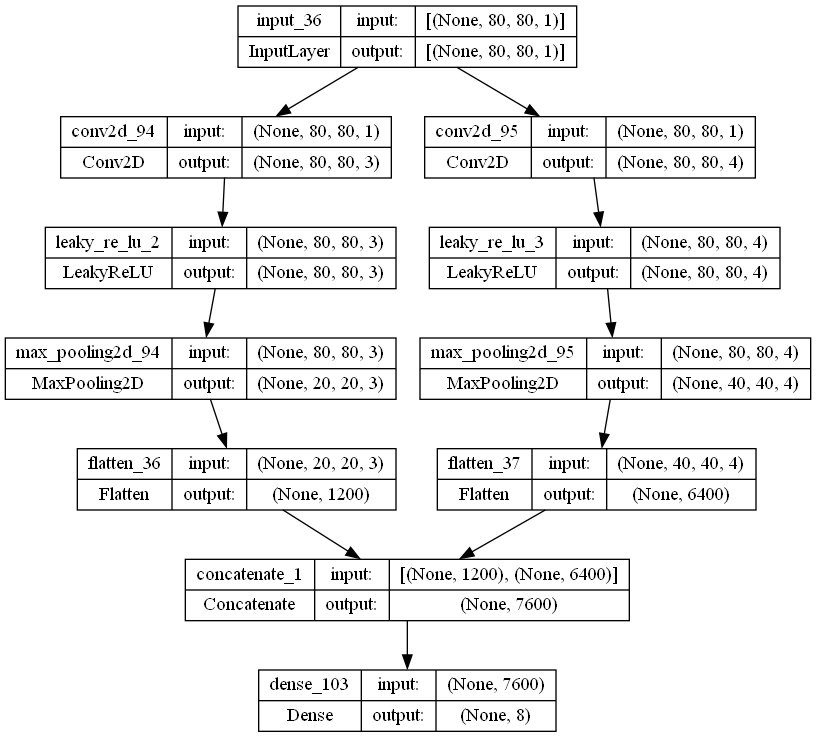

In [86]:
def make_model(input_shape):
    """
    Build keras model
    Compute branch1 and branch2 then concat and pass to output layer
    """
    inputs = keras.Input(shape=input_shape)

    # branch 1
    branch1 = keras.layers.Conv2D(filters=3, kernel_size=8, padding="same")(inputs)
    branch1 = keras.layers.LeakyReLU(alpha=0.3)(branch1)
    branch1 = keras.layers.MaxPool2D(pool_size=4)(branch1)
    branch1 = keras.layers.Flatten()(branch1)
    
    # branch 2

    branch2 = keras.layers.Conv2D(filters=4, kernel_size=4, padding="same")(inputs)
    branch2 = keras.layers.LeakyReLU(alpha=0.3)(branch2)
    branch2 = keras.layers.MaxPool2D(pool_size=2)(branch2)
    branch2 = keras.layers.Flatten()(branch2)

    # merge

    merge = keras.layers.Concatenate(axis=1)([branch1, branch2])
    outputs = keras.layers.Dense(8, activation="softmax")(merge)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=(80, 80, 1))
keras.utils.plot_model(model, show_shapes=True)  # model visualization

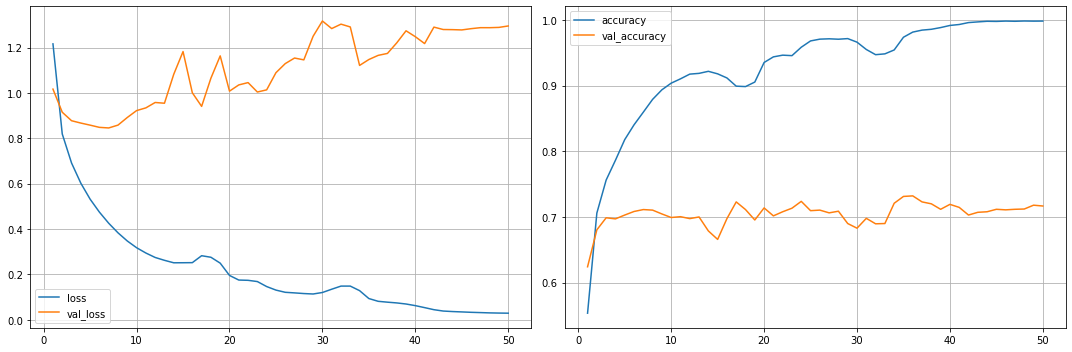

In [87]:
epochs = 50

callbacks = [
    PlotLearning()
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
    verbose=0
)


P1.2

In [2]:
def reduce_dimension(x, y):
    """
    Remove last dim
    """
    return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)
_ = train_dataset_squeeze.batch(128), val_dataset_squeeze.batch(128)

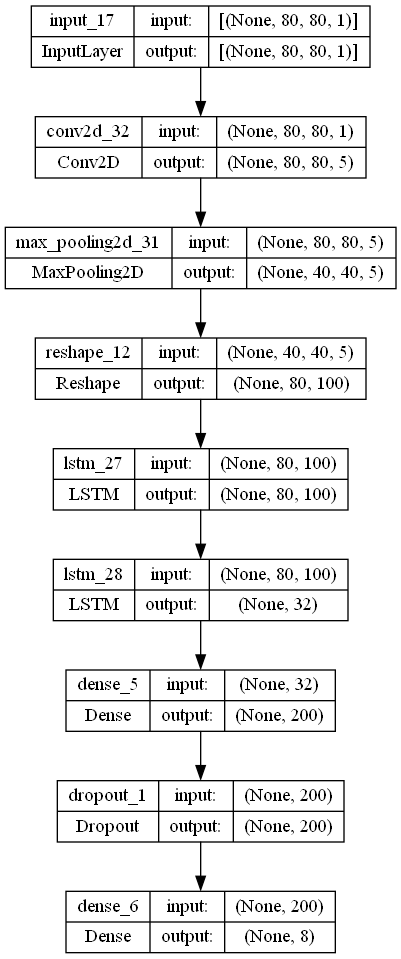

In [67]:
def make_rnn_model(input_shape):
    """
    Changed number of filters and LSTM units and added a reshape layer to make conv outputs 
    compatible with lstm inputs
    """
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(filters=8, kernel_size=4, padding="same")(inputs)
    x = keras.layers.MaxPool2D(pool_size=2)(x)
    x = keras.layers.Conv2D(filters=5, kernel_size=3, padding="same")(inputs)
    x = keras.layers.MaxPool2D(pool_size=2)(x)
    x = keras.layers.Reshape(target_shape=(80, 100))(x)
    x = keras.layers.LSTM(units=100, return_sequences=True)(x)
    x = keras.layers.LSTM(units=32)(x)
    x = keras.layers.Dense(units=200, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(units=8, activation="softmax")(x)
    return keras.Model(inputs, outputs)


model = make_rnn_model(input_shape=(80, 80, 1))
keras.utils.plot_model(model, show_shapes=True)

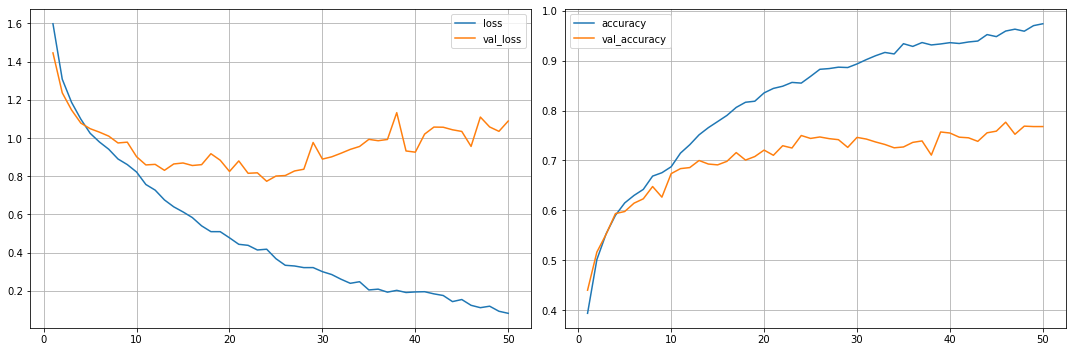

In [68]:
epochs = 50

callbacks = [
    PlotLearning()
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
    verbose=0
)


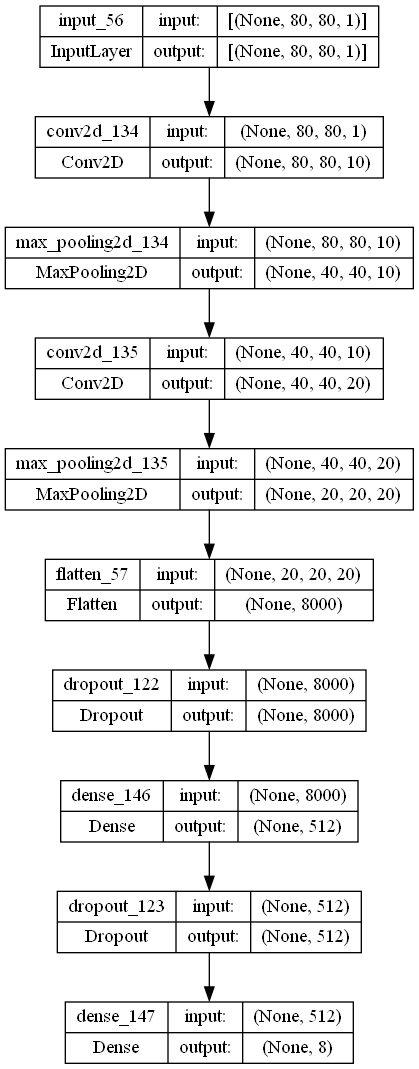

In [127]:
def make_better_model(input_shape):
    """
    Build model.
    """
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(filters=10, kernel_size=3, padding="same")(inputs)
    x = keras.layers.MaxPool2D(pool_size=2)(x)
    x = keras.layers.Conv2D(filters=20, kernel_size=3, padding="same")(x)
    x = keras.layers.MaxPool2D(pool_size=2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=512, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units=8, activation="softmax")(x)
    return keras.Model(inputs, outputs)

tf.random.set_seed(42)  # manual seed for reproducibility 
model = make_better_model(input_shape=(80, 80, 1))
keras.utils.plot_model(model, show_shapes=True)

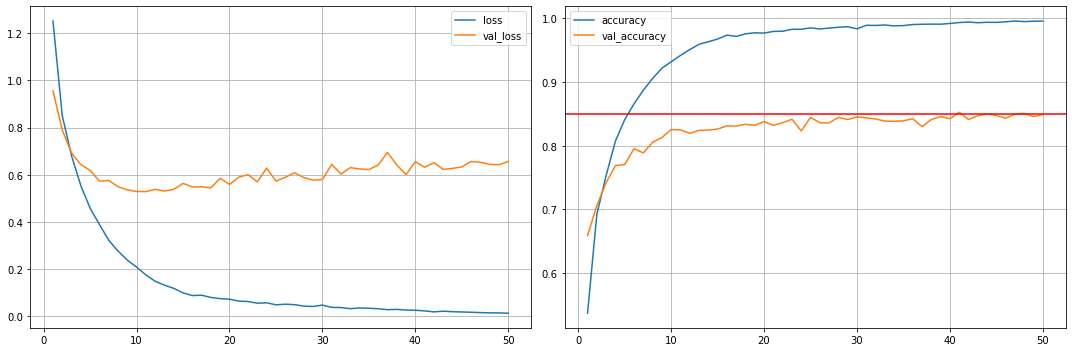

1200/1200 [==============================] - 8s 6ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.6561 - val_accuracy: 0.8492 - lr: 2.2313e-05
max val_acc: 0.8525000214576721


In [128]:
epochs = 50
def scheduler(epoch, lr):
    if epoch < 35:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

data_augmentation = keras.Sequential([keras.layers.RandomFlip("horizontal")])

train_dataset = tf.data.Dataset.load("assign2_train").batch(8)  # lowering batch size usually improves accuracy 
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))  # augment data by adding random horizontal flip
val_dataset = tf.data.Dataset.load("assign2_val").batch(128)
callbacks = [
    PlotLearning(0.85),  # add horizontal line at 0.85 to accuracy plot
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
    verbose=1
)
print("max val_acc:", max(history.history["val_accuracy"]))